In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# load packages
import sys # access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import numpy as np # scientific computing
print("NumPy version: {}". format(np.__version__))

import pandas as pd # data processing and analysis 
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt # plotting
%matplotlib inline 
print("matplotlib version: {}". format(matplotlib.__version__))
 
import sklearn # machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

from itertools import product
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import time
from sklearn.preprocessing import LabelEncoder


print("----------")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
NumPy version: 1.18.5
pandas version: 1.1.2
matplotlib version: 3.2.1
scikit-learn version: 0.23.2
----------
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/pfs-featureengineering1/__results__.html
/kaggle/input/pfs-featureengineering1/all_data_withFeatures.pkl
/kaggle/input/pfs-featureengineering1/__notebook__.ipynb
/kaggle/input/pfs-featureengineering1/custom.css
/kaggle/input/pfs-featureengineering1/__output__.json


# Load Data
Load data prepared in PFS-FeatureEngineering1 and original data where needed.

In [2]:
# read csv file into data frames
#df_items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
#df_shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv') # read cleaned version instead later
df_sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
#df_item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
#df_sample_submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

# my versions
all_data = pd.read_pickle('../input/pfs-featureengineering1/all_data_withFeatures.pkl')
all_data.head()

,shop_id,item_id,date_block_num,target,item_target_enc_kf,item_target_enc_loo,item_target_enc_sm,item_target_enc_ems,item_category_id,days_per_month,...,monthly_transactions_lag_4,monthly_transactions_lag_5,monthly_transactions_lag_12,price_trend,acc_price_lag,name_sqbrac,name_brac,word1,word12,type
0,59,22154,0,1.0,0.084746,0.108209,0.145052,0.333984,37,31,...,0.0,0.0,0.0,0.0,0.0,4,548,4293,8301,0
1,59,2552,0,0.0,0.021583,0.018248,0.102396,0.333984,58,31,...,0.0,0.0,0.0,0.0,0.0,4,41,292,530,0
2,59,2554,0,0.0,0.333984,0.022727,0.237230,0.333984,58,31,...,0.0,0.0,0.0,0.0,0.0,4,41,292,530,0
3,59,2555,0,0.0,0.056995,0.066508,0.094802,0.333984,56,31,...,0.0,0.0,0.0,0.0,0.0,4,1511,292,530,0
4,59,2564,0,0.0,0.040307,0.058599,0.089614,0.333984,59,31,...,0.0,0.0,0.0,0.0,0.0,4,1124,292,530,0


# Set Validation Strategy


In [3]:
# check if using month 33 as validation data is a good idea
new_items = len(list(set(df_test.item_id) - set(df_test.item_id).intersection(set(df_sales.item_id))))
print("Month 34: \n New items: %4d \n No of items: %5d \n No of item-shop pairs: %6d" % (new_items, len(list(set(df_test.item_id))), len(df_test)))
val_data = df_sales[df_sales.date_block_num == 33]
train_data = df_sales[df_sales.date_block_num < 33]
new_items = len(list(set(val_data.item_id) - set(val_data.item_id).intersection(set(train_data.item_id))))
print("Month 33: \n New items: %4d \n No of items: %5d \n No of item-shop pairs: %6d" % (new_items, len(list(set(val_data.item_id))), len(val_data)))
# both month have new data. the differnce in shop-items pais is likely to come from the fact that df_sales contains only items that have been sold
# whereas the test data is likely to contain 0 for a lot of item-shop pairs

Month 34: 
 New items:  363 
 No of items:  5100 
 No of item-shop pairs: 214200
Month 33: 
 New items:  475 
 No of items:  5413 
 No of item-shop pairs:  53514


In [4]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_target_enc_kf',
       'item_target_enc_loo', 'item_target_enc_sm', 'item_target_enc_ems',
       'item_category_id', 'days_per_month', 'month', 'city_code',
       'item_bcat_code', 'item_scat_code', 'target_lag_1', 'target_lag_2',
       'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12',
       'month_item_sum_lag_1', 'month_item_sum_lag_2', 'month_item_sum_lag_3',
       'month_item_sum_lag_4', 'month_item_sum_lag_5', 'month_item_sum_lag_12',
       'month_shop_sum_lag_1', 'month_shop_sum_lag_2', 'month_shop_sum_lag_3',
       'month_shop_sum_lag_4', 'month_shop_sum_lag_5', 'month_shop_sum_lag_12',
       'month_sum_lag_1', 'month_sum_lag_2', 'month_sum_lag_3',
       'month_sum_lag_4', 'month_sum_lag_5', 'month_sum_lag_12',
       'monthly_transactions_lag_1', 'monthly_transactions_lag_2',
       'monthly_transactions_lag_3', 'monthly_transactions_lag_4',
       'monthly_transactions_lag_5', 'monthly_trans

In [5]:
#select columns for training data
columns = ['shop_id', 'item_id', 'date_block_num', #'item_target_enc_kf',
       #'item_target_enc_loo', 'item_target_enc_sm', 'item_target_enc_ems',
       'item_category_id', 'days_per_month', 'month', 'city_code',
       'item_bcat_code', 'item_scat_code', 'target_lag_1', 'target_lag_2',
       'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12',
       'month_item_sum_lag_1', 'month_item_sum_lag_2', 'month_item_sum_lag_3',
       'month_item_sum_lag_4', 'month_item_sum_lag_5', 'month_item_sum_lag_12',
       'month_shop_sum_lag_1', 'month_shop_sum_lag_2', 'month_shop_sum_lag_3',
       'month_shop_sum_lag_4', 'month_shop_sum_lag_5', 'month_shop_sum_lag_12',
       'month_sum_lag_1', 'month_sum_lag_2', 'month_sum_lag_3',
       'month_sum_lag_4', 'month_sum_lag_5', 'month_sum_lag_12',
       'monthly_transactions_lag_1', 'monthly_transactions_lag_2',
       'monthly_transactions_lag_3', 'monthly_transactions_lag_4',
       'monthly_transactions_lag_5', 'monthly_transactions_lag_12',
       'price_trend', 'acc_price_lag', 'name_sqbrac', 'name_brac', #'word1',
       #'word12', 'type'
          ]
if 'target' in columns:
    print("You are a stuipd moron!")

In [6]:
# lets use month 33 as validation data and month 3/12-32 as training data, drop frist months due to lag feature

X_val = all_data[all_data.date_block_num == 33] # month 33 data
y_val = X_val["target"]
X_val = X_val[columns]

#X_train = all_data[(all_data.date_block_num >2) & (all_data.date_block_num < 33)] # month 3-32 data
X_train = all_data[(all_data.date_block_num >11) & (all_data.date_block_num < 33)] # month 12-32 data
y_train = X_train["target"]
X_train = X_train[columns]

X_test = all_data[all_data.date_block_num == 34][columns]

In [7]:
#print(X_train.head())
#print(X_val.head())
#print(y_train.head())
#print(y_val.head())
print(X_test.head())

          shop_id  item_id  date_block_num  item_category_id  days_per_month  \
10913804        5     5037              34                19              30   
10913805        5     5320              34                55              30   
10913806        5     5233              34                19              30   
10913807        5     5232              34                23              30   
10913808        5     5268              34                20              30   

          month  city_code  item_bcat_code  item_scat_code  target_lag_1  ...  \
10913804     11          4               3              10           0.0  ...   
10913805     11          4               7               2           0.0  ...   
10913806     11          4               3              10           1.0  ...   
10913807     11          4               3              16           0.0  ...   
10913808     11          4               3              11           0.0  ...   

          monthly_transactions_l

In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 51 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int8   
 1   item_id                      int16  
 2   date_block_num               int64  
 3   target                       float64
 4   item_target_enc_kf           float32
 5   item_target_enc_loo          float32
 6   item_target_enc_sm           float32
 7   item_target_enc_ems          float32
 8   item_category_id             int8   
 9   days_per_month               int8   
 10  month                        int8   
 11  city_code                    int8   
 12  item_bcat_code               int8   
 13  item_scat_code               int8   
 14  target_lag_1                 float32
 15  target_lag_2                 float32
 16  target_lag_3                 float32
 17  target_lag_4                 float32
 18  target_lag_5                 float32
 19

# Fit Model
Now I have the data in a state to fit a model. After using XGBoost for a long time I switched to LightGBM with the parameters from the Programming Asssignment week 4.

In [9]:
# try out light gbm with parameters from programming assignment to check if it is faster than xgboost with the same input data
# 100 trees with no early stopping give fast and ok result. with 1000 trees and early stopping 30 result will be better but much longer training.
ts = time.time()

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train, label=y_train), 
                  1000,  
                  valid_sets=[lgb.Dataset(X_train, label=y_train),lgb.Dataset(X_val, label=y_val)], 
                  valid_names=['train', 'val'],
                  early_stopping_rounds=30
                 )

time.time() - ts

[1]	train's rmse: 1.17225	val's rmse: 1.12399
Training until validation scores don't improve for 30 rounds
[2]	train's rmse: 1.15676	val's rmse: 1.11343
[3]	train's rmse: 1.14366	val's rmse: 1.10532
[4]	train's rmse: 1.1295	val's rmse: 1.09504
[5]	train's rmse: 1.11683	val's rmse: 1.08621
[6]	train's rmse: 1.10363	val's rmse: 1.07679
[7]	train's rmse: 1.09111	val's rmse: 1.06796
[8]	train's rmse: 1.08002	val's rmse: 1.06123
[9]	train's rmse: 1.06855	val's rmse: 1.0533
[10]	train's rmse: 1.05879	val's rmse: 1.04772
[11]	train's rmse: 1.04934	val's rmse: 1.0417
[12]	train's rmse: 1.03932	val's rmse: 1.0344
[13]	train's rmse: 1.03055	val's rmse: 1.02967
[14]	train's rmse: 1.02115	val's rmse: 1.02351
[15]	train's rmse: 1.01369	val's rmse: 1.01888
[16]	train's rmse: 1.00509	val's rmse: 1.01346
[17]	train's rmse: 0.996656	val's rmse: 1.00902
[18]	train's rmse: 0.988773	val's rmse: 1.00419
[19]	train's rmse: 0.981512	val's rmse: 1.00002
[20]	train's rmse: 0.974509	val's rmse: 0.99527
[21]	tra

866.7964870929718

In [10]:
#predict with X_test
y_test = model.predict(X_test)
print("Prediction done!")
print("max value before clipping: ", y_test.max())
print("min value before clipping: ", y_test.min())
y_test = y_test.clip(0, 20)

Prediction done!
max value before clipping:  21.20832844776623
min value before clipping:  -0.35295831294363517


In [11]:
# create final submission file
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('submission.csv', index=False)

In [12]:
# save predictions for ensemble
predictionsLGB = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": y_test
})
predictionsLGB.to_csv('predictionsLGB.csv', index=False)

In [13]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

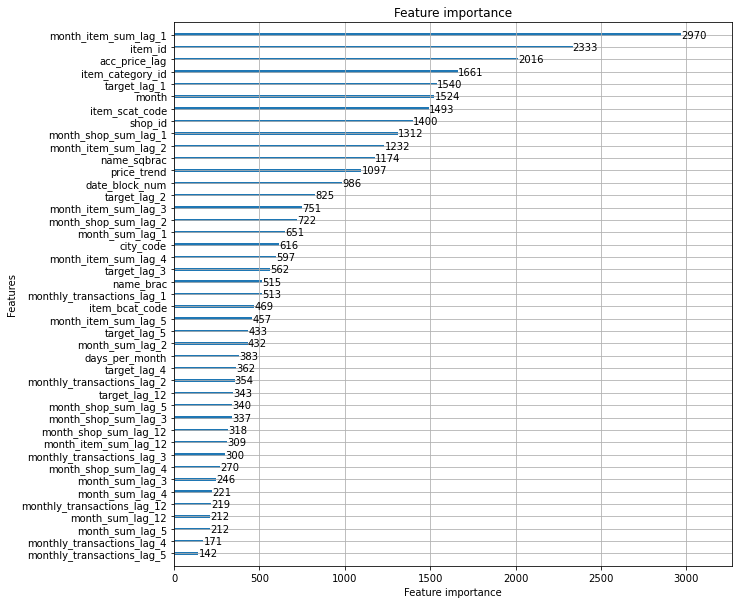

In [14]:
lgb.plot_importance(model, figsize=(10,10))
plt.show()